# **House Sale Price Predictor**

## Objectives

* Fit and evaluate a regression model to predict sale prices of inherited houses

## Inputs

* outputs/datasets/cleaned/HousePricesCleaned.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict house prices
* Feature Importance Plot
* Model performance plot





---

## Install basic requirements

In [11]:
%pip install -r ../requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [12]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing2/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [13]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [14]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing2'

In [15]:
pip install numpy


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Load House Price Data

We will load the house prices dataset and check for any missing values in the variables, addressing them as necessary in the upcoming sections.

In [55]:
import pandas as pd
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from sklearn.linear_model import LinearRegression

# Load the dataset
df = pd.read_csv("/workspace/heritage-housing2/outputs/datasets/collection/HousePrices.csv")

# Step 1: Impute missing values for numerical variables with median
imputer_num = MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])
df = imputer_num.fit_transform(df)

# Step 2: Impute missing values for categorical variables with 'missing' or 'Unf'
imputer_cat = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])
df = imputer_cat.fit_transform(df)

# Step 3: Impute missing values for specific variables with an arbitrary number (0 in this case)
arbitrary_vars = ['EnclosedPorch', '1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF']
imputer_arbitrary = ArbitraryNumberImputer(arbitrary_number=0, variables=arbitrary_vars)
df = imputer_arbitrary.fit_transform(df)

# Check if there are any remaining missing values in the imputed DataFrame
print("Remaining missing values after imputation:")
print(df.isnull().sum().sum())

# Check for missing data columns in the imputed DataFrame
missing_data = df.isnull().sum()
print("\nColumns with missing data:")
print(missing_data[missing_data > 0])

Remaining missing values after imputation:
0

Columns with missing data:
Series([], dtype: int64)


In [56]:
# Check for missing data
missing_data = df.isnull().sum()
print("\nColumns with missing data:")
print(missing_data[missing_data > 0])


Columns with missing data:
Series([], dtype: int64)


---

# Create Machine Learning Pipeline
* The pipeline will be of type regression.

In [57]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.outliers   import Winsorizer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection, DropFeatures
from feature_engine import transformation as vt

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF','MasVnrArea'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing',fill_value='Unf', variables=['GarageFinish','BsmtFinType1'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF','GarageArea','TotalBsmtSF'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['LotArea'])),

        ("Winsorizer",Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GrLivArea'])),
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling - Standardize features by removing the mean and scaling to unit variance.
        ("scaler", StandardScaler()),

        # Feature Selection - Meta-transformer for selecting features based on importance weights.
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

## Optimize Hyperparameter - GridSearchCV

In [58]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train Data Test Set

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


## Cross Validate Grid Search - Sklearn 
* Identify most suitable algorithm using default hyperparameters

## Prepare Dictionaries for Model Comparison and Hyperparameter Optimization

In [60]:
models_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

## Run Hyper Optimization Search

In [61]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprec

## Display grid search summary

In [62]:
import numpy as np
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.643677,0.773052,0.833795,0.067359
2,RandomForestRegressor,0.61857,0.75289,0.821982,0.070103
3,ExtraTreesRegressor,0.610624,0.747463,0.792766,0.069215
0,LinearRegression,0.683862,0.741346,0.838822,0.052783
6,XGBRegressor,0.637822,0.674272,0.705139,0.025922
4,AdaBoostRegressor,0.507364,0.664698,0.733887,0.088384
1,DecisionTreeRegressor,0.352237,0.520171,0.646729,0.107578


We identified the GradientBoostingRegressor as the most suitable model in the previous section.

## Display the results of the extensive search for hyperparameters

In [63]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

In [64]:
# defining model parameters for a more extensive search

models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# In a workplace project, you may consider more hyperparameters and spend more time in this step
# https://inria.github.io/scikit-learn-mooc/python_scripts/ensemble_hyperparameters.html

params_search = {
    "GradientBoostingRegressor": {
        'model__learning_rate': [0.05],
        'model__n_estimators': [100],
        'model__max_depth': [5],
        'model__min_samples_split': [5],
        'model__min_samples_leaf': [1],
        'model__max_leaf_nodes': [10],
    }
}

In [65]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [42]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate
0,GradientBoostingRegressor,0.692948,0.782835,0.829671,0.050437,0.05


In [66]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

In [44]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.05}

In [67]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImputer(variables...
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                      

# Final pipeline for storage

In [49]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# In a workplace project, you may consider more hyperparameters and spend more time in this step
# https://inria.github.io/scikit-learn-mooc/python_scripts/ensemble_hyperparameters.html

params_search = {
    "GradientBoostingRegressor": {
        'model__learning_rate': [0.05],
        'model__n_estimators': [100],
        'model__max_depth': [5],
        'model__min_samples_split': [5],
        'model__min_samples_leaf': [1],
        'model__max_leaf_nodes': [10],
    }
}

In [50]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [51]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,GradientBoostingRegressor,0.697341,0.790033,0.834748,0.04904,0.05,5,10,1,5,100


In [52]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

In [53]:
pipeline_regression = grid_search_pipelines[best_model].best_estimator_
pipeline_regression

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImputer(variables...
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                                                     'OverallQual',
        

NameError: name 'regression_performance' is not defined

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']


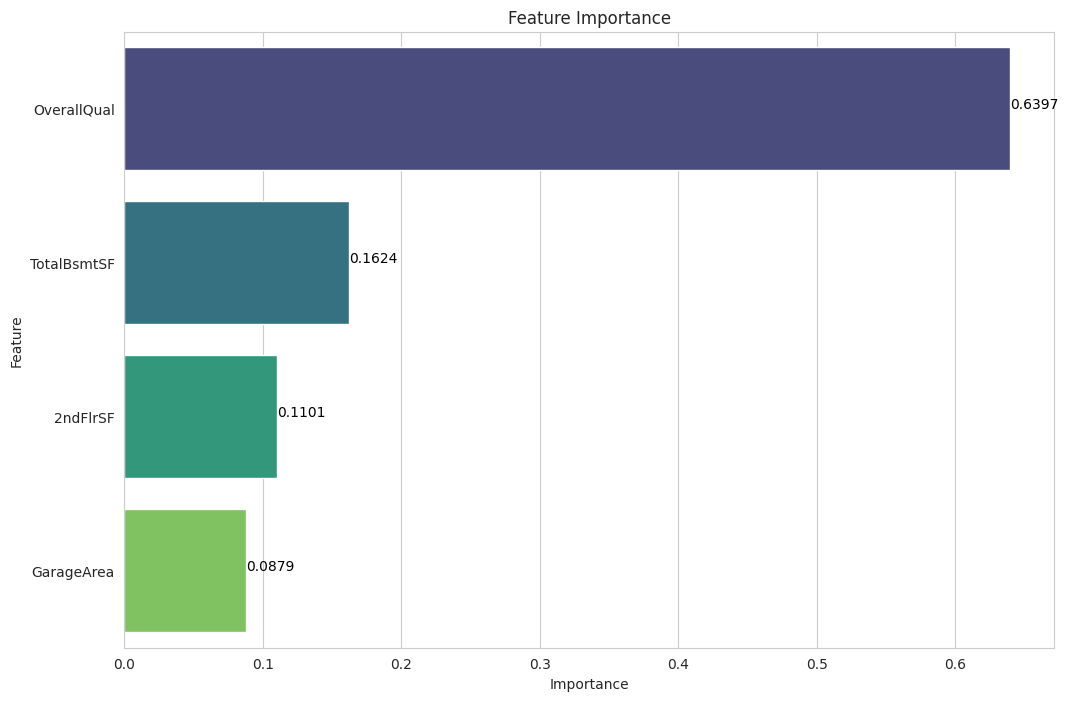

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changed
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 10 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

# Plot the feature importance with values on top of the bars
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Importance', y='Feature', data=df_feature_importance, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Add values on top of the bars
for index, value in enumerate(df_feature_importance['Importance']):
    barplot.text(value, index, f'{value:.4f}', color='black', ha="left")

plt.show()

## Evaluate Train and Test Data Sets

In [69]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

## Display performance and evalutation plots for the regressor model

Model Evaluation 

* Train Set
R2 Score: 0.906
Mean Absolute Error: 17783.587
Mean Squared Error: 580749250.131
Root Mean Squared Error: 24098.74


* Test Set
R2 Score: 0.832
Mean Absolute Error: 22484.658
Mean Squared Error: 1158042518.86
Root Mean Squared Error: 34030.024




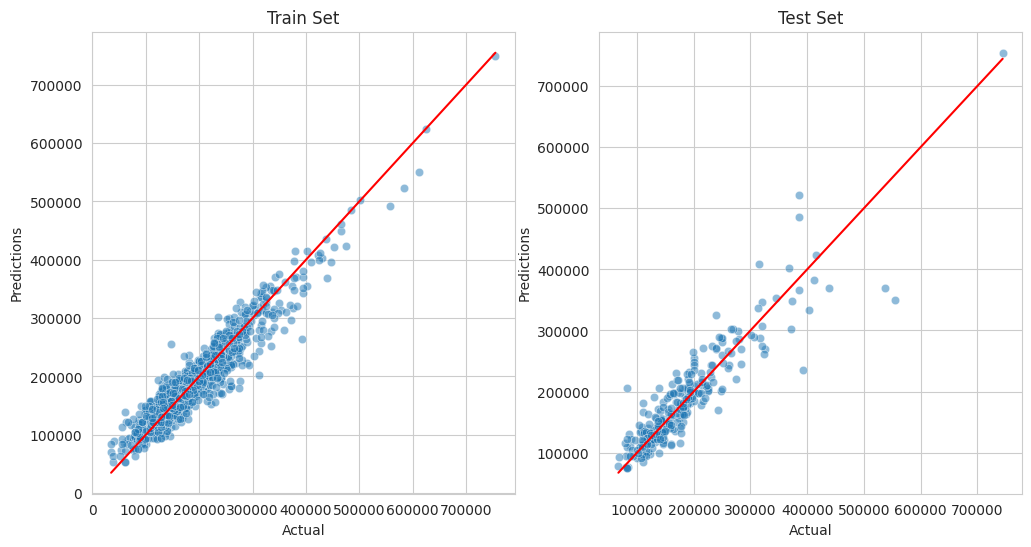

In [70]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---

# First conclusion and next steps
We noticed that the feature importance for OverallQual was significantly higher than any other feature in the dataset. While our model evaluation scores for both the training and test sets were high, we wanted to ensure the model's stability and robustness. To investigate this, we employed three methods: Partial Dependence Plot (PDP), checking model performance without OverallQual, and Permutation Importance. These methods can provide a comprehensive understanding of the feature's impact and help verify the model's reliability.

---

# Partial Dependence Plot

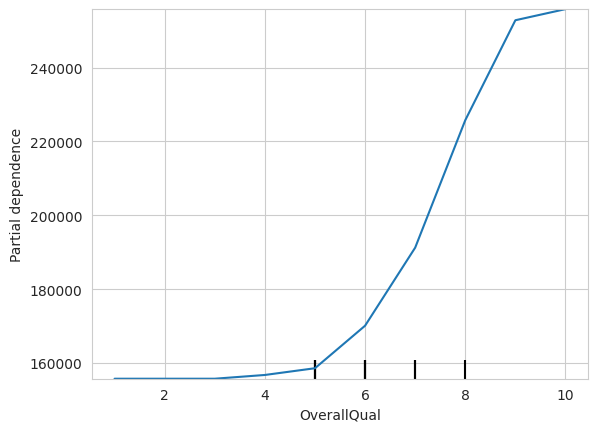

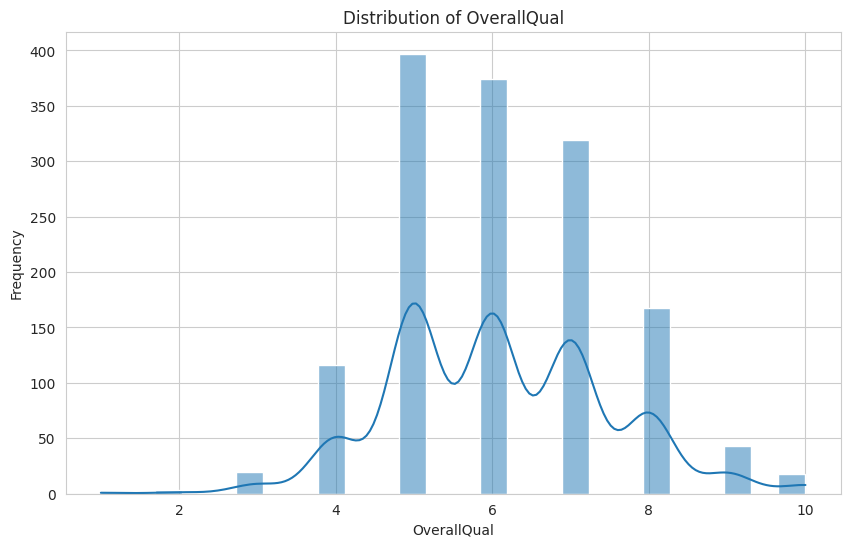

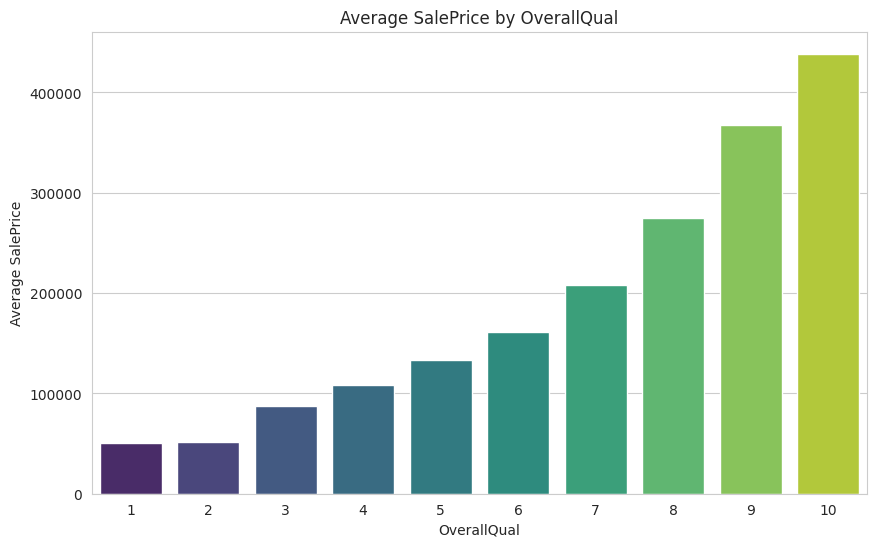

In [71]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from feature_engine.encoding import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv("/workspace/heritage-housing2/outputs/datasets/collection/HousePrices.csv")

# Define features and target
X = df.drop(columns=['SalePrice'])  # Replace 'SalePrice' with your target column name
y = df['SalePrice']

# Imputation strategies
imputer_num = MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])
imputer_cat = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])
imputer_arbitrary = ArbitraryNumberImputer(arbitrary_number=0, variables=['EnclosedPorch','1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF'])

# Fit and transform the data
X = imputer_num.fit_transform(X)
X = imputer_cat.fit_transform(X)
X = imputer_arbitrary.fit_transform(X)

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['number']).columns.tolist()

# Ordinal encoding for certain categorical features
encoder = OrdinalEncoder(encoding_method='arbitrary', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])
X = encoder.fit_transform(X)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline that first preprocesses the data then trains the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor())
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Plot the PDP for the dominant feature 'OverallQual'
dominant_feature = 'OverallQual'  # Your dominant feature

# Plot the Partial Dependence
plot_partial_dependence(model_pipeline, X_train, [dominant_feature], grid_resolution=50)
plt.show()

# Create a distribution plot for 'OverallQual'
plt.figure(figsize=(10, 6))
sns.histplot(df['OverallQual'], kde=True)
plt.title('Distribution of OverallQual')
plt.xlabel('OverallQual')
plt.ylabel('Frequency')
plt.show()

# Calculate the average SalePrice for each OverallQual rating
overall_qual_avg_price = df.groupby('OverallQual')['SalePrice'].mean().reset_index()

# Plot the relationship between OverallQual and average SalePrice
plt.figure(figsize=(10, 6))
sns.barplot(x='OverallQual', y='SalePrice', data=overall_qual_avg_price, palette='viridis')
plt.title('Average SalePrice by OverallQual')
plt.xlabel('OverallQual')
plt.ylabel('Average SalePrice')
plt.show()

# Model performance with OverallQual

In [72]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from feature_engine.encoding import OrdinalEncoder

# Load your dataset
df = pd.read_csv("/workspace/heritage-housing2/outputs/datasets/collection/HousePrices.csv")

# Define features and target
X = df.drop(columns=['SalePrice'])  # Replace 'SalePrice' with your target column name
y = df['SalePrice']

# Imputation strategies
imputer_num = MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])
imputer_cat = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])
imputer_arbitrary = ArbitraryNumberImputer(arbitrary_number=0, variables=['EnclosedPorch','1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF'])

# Fit and transform the data
X = imputer_num.fit_transform(X)
X = imputer_cat.fit_transform(X)
X = imputer_arbitrary.fit_transform(X)

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['number']).columns.tolist()

# Ordinal encoding for certain categorical features
encoder = OrdinalEncoder(encoding_method='arbitrary', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])
X = encoder.fit_transform(X)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline that first preprocesses the data then trains the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Evaluate the model with OverallQual
score_with_qual = model_pipeline.score(X_test, y_test)
print(f"Model performance with OverallQual: {score_with_qual}")

Model performance with OverallQual: 0.8946362669038835


# Model performance without OverallQual

In [73]:
# Remove the 'OverallQual' feature from the training and test sets
X_train_wo_qual = X_train.drop(columns=['OverallQual'])
X_test_wo_qual = X_test.drop(columns=['OverallQual'])

# Define a new preprocessing pipeline for the dataset without 'OverallQual'
preprocessor_wo_qual = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', [col for col in numeric_features if col != 'OverallQual']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a new model pipeline without 'OverallQual'
model_pipeline_wo_qual = Pipeline(steps=[
    ('preprocessor', preprocessor_wo_qual),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Train the new model
model_pipeline_wo_qual.fit(X_train_wo_qual, y_train)

# Evaluate the model without OverallQual
score_wo_qual = model_pipeline_wo_qual.score(X_test_wo_qual, y_test)
print(f"Model performance without OverallQual: {score_wo_qual}")

Model performance without OverallQual: 0.8933124702388011


# Prepare Permutation Importance test

In [74]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from feature_engine.encoding import OrdinalEncoder

# Load your dataset
df = pd.read_csv("/workspace/heritage-housing2/outputs/datasets/collection/HousePrices.csv")

# Define features and target
X = df.drop(columns=['SalePrice'])  # Replace 'SalePrice' with your target column name
y = df['SalePrice']

# Imputation strategies
imputer_num = MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])
imputer_cat = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])
imputer_arbitrary = ArbitraryNumberImputer(arbitrary_number=0, variables=['EnclosedPorch','1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF'])

# Fit and transform the data
X = imputer_num.fit_transform(X)
X = imputer_cat.fit_transform(X)
X = imputer_arbitrary.fit_transform(X)

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['number']).columns.tolist()

# Ordinal encoding for certain categorical features
encoder = OrdinalEncoder(encoding_method='arbitrary', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])
X = encoder.fit_transform(X)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline that first preprocesses the data then trains the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['1stFlrSF', '2ndFlrSF',
                                                   'BedroomAbvGr', 'BsmtFinSF1',
                                                   'BsmtUnfSF', 'EnclosedPorch',
                                                   'GarageArea', 'GarageYrBlt',
                                                   'GrLivArea', 'LotArea',
                                                   'LotFrontage', 'MasVnrArea',
                                                   'OpenPorchSF', 'OverallCond',
                                                   'OverallQual', 'TotalBsmtSF',
                                                   'WoodDeckSF', 'YearBuilt',
                                                   'YearRemodAdd']),
                                                 ('cat',
                                                  OneHotE

# Display permuation importance - table

In [75]:
from sklearn.inspection import permutation_importance

# Compute permutation feature importance
perm_importance = permutation_importance(model_pipeline, X_test, y_test, n_repeats=10, random_state=42)

# Extract importance scores and feature names
importance_scores = perm_importance.importances_mean
feature_names = X.columns

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
}).sort_values(by='Importance', ascending=False)

print(importance_df)

          Feature  Importance
18    OverallQual    0.283174
11      GrLivArea    0.137477
21      YearBuilt    0.038877
1        2ndFlrSF    0.031308
19    TotalBsmtSF    0.026276
0        1stFlrSF    0.015696
13        LotArea    0.015399
12    KitchenQual    0.014532
8      GarageArea    0.014268
4      BsmtFinSF1    0.010401
17    OverallCond    0.008692
22   YearRemodAdd    0.007708
3    BsmtExposure    0.003428
16    OpenPorchSF    0.002151
14    LotFrontage    0.000514
15     MasVnrArea    0.000512
9    GarageFinish    0.000362
7   EnclosedPorch    0.000000
5    BsmtFinType1    0.000000
10    GarageYrBlt   -0.000073
2    BedroomAbvGr   -0.000221
20     WoodDeckSF   -0.000776
6       BsmtUnfSF   -0.001482


# Display permuation importance - plot

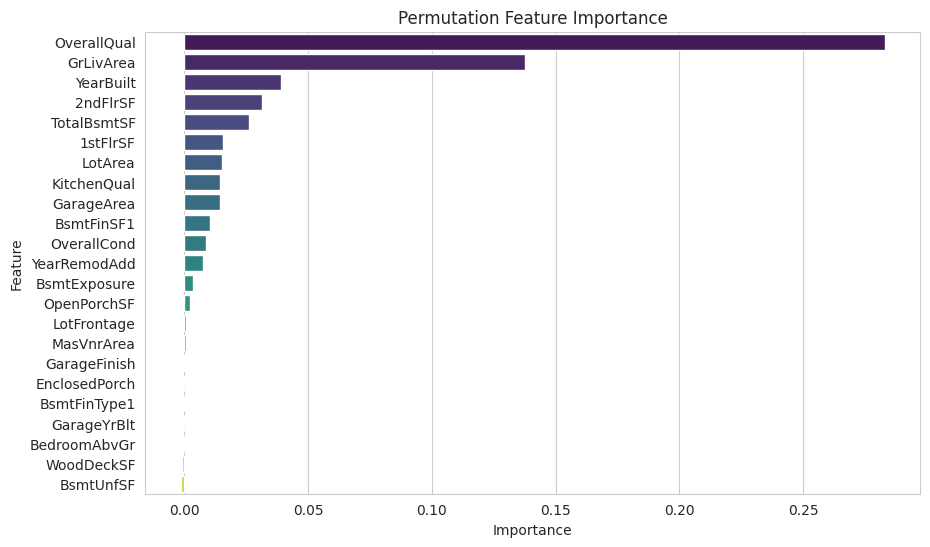

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot permutation feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Permutation Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

---

# Summary
* Dominant Feature: OverallQual is consistently identified as the most important feature across all methods, with substantial influence on the model's predictions.
* Supporting Features: GrLivArea, TotalBsmtSF, and 2ndFlrSF are also important, though less influential than OverallQual.
* Consistent Insights: The PDP and feature importance plots provide consistent insights, showing a clear, positive relationship between OverallQual and SalePrice.
* Balanced Model: The permutation importance method further validates the model's balanced reliance on multiple features, ensuring robustness and interpretability.
* These findings suggest that OverallQual is a crucial predictor of house prices in your dataset, but the model also benefits from incorporating other significant features. This balanced importance distribution helps in building a robust and generalizable model.

## Details: 
**1. Feature Importance (Model-Based)**
- The feature importance scores derived from the model indicate the relative importance of each feature in predicting the target variable (SalePrice).

  - OverallQual: 0.6540
  - TotalBsmtSF: 0.1500
  - 2ndFlrSF: 0.1048
  - GarageArea: 0.0912


**2. Partial Dependence Plot (PDP)** 
- The PDP shows the marginal effect of OverallQual on the predicted SalePrice, giving an intuitive understanding of how changes in this feature affect the target variable.

PDP Values for OverallQual (Quality level and average sale price):
  - 1,2: ~$50,000
    - 3: ~ $80,000
    * 4: ~ $105,000
    * 5: ~ $125,000
    * 6: ~ $150,000
    * 7: ~ $205,000
    * 8: ~ $270,000
    * 9: ~ $360,000
    * 10: ~ $440,000
- The PDP indicates a nearly linear relationship between OverallQual and SalePrice, with higher quality ratings significantly increasing the predicted price.

**3. Permutation Importance**
- Permutation importance measures the impact of shuffling a feature's values on the model performance, providing another perspective on feature significance.

* OverallQual: 0.283174
* GrLivArea: 0.137477
* YearBuilt: 0.038877
* 2ndFlrSF: 0.031308
* TotalBsmtSF: 0.026276
* 1stFlrSF: 0.015696
* LotArea: 0.015399
* KitchenQual: 0.014532
* GarageArea: 0.014268
This method confirms the importance of OverallQual, while also highlighting GrLivArea as a significant feature. YearBuilt, 2ndFlrSF, and TotalBsmtSF also play important roles but to a lesser extent.

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [29]:
import joblib
import os

# Define the version and file path relative to the project's root directory
version = 'v14_test'
file_path = os.path.join('/workspace/heritage-housing2/outputs/ml_pipeline/predict_sale_price', version)

try:
    os.makedirs(file_path, exist_ok=True)
except Exception as e:
    print(e)

## Train Set : features and target

In [30]:
X_train.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
618,1828,0.0,3.0,Av,48,Unf,1774,0.0,774,Unf,...,11694,90.0,452.0,108,5,9,1822,0.0,2007,2007
870,894,0.0,2.0,No,0,Unf,894,0.0,308,Unf,...,6600,60.0,0.0,0,5,5,894,0.0,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,0.0,432,Unf,...,13360,80.0,0.0,0,7,5,876,0.0,1921,2006
817,1689,0.0,3.0,No,1218,GLQ,350,0.0,857,RFn,...,13265,69.0,148.0,59,5,8,1568,0.0,2002,2002
302,1541,0.0,3.0,No,0,Unf,1541,0.0,843,RFn,...,13704,118.0,150.0,81,5,7,1541,0.0,2001,2002


In [31]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [36]:
y_train.head()

921     145900
520     106250
401     164990
280     228500
1401    193000
Name: SalePrice, dtype: int64

In [32]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

X_test.head()

In [33]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [34]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [35]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

In [36]:
pipeline_regression

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['1stFlrSF', '2ndFlrSF',
                                                   'BedroomAbvGr', 'BsmtFinSF1',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   'GarageArea', 'GrLivArea',
                                                   'LotArea', 'LotFrontage',
                                                   'MasVnrArea',
                                                   'OpenPorchSF'])),
                ('CategoricalImputer'...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
         

In [37]:
joblib.dump(value=pipeline_regression, filename=f"{file_path}/regression_pipeline.pkl")

['/workspace/heritage-housing2/outputs/ml_pipeline/predict_sale_price/v14_test/regression_pipeline.pkl']

## Feature Importance Plot 

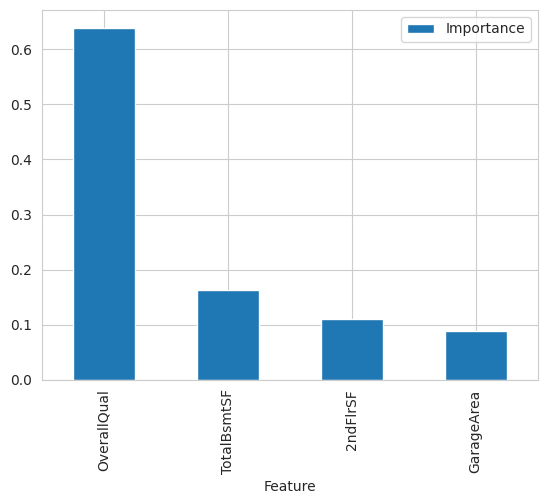

In [80]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

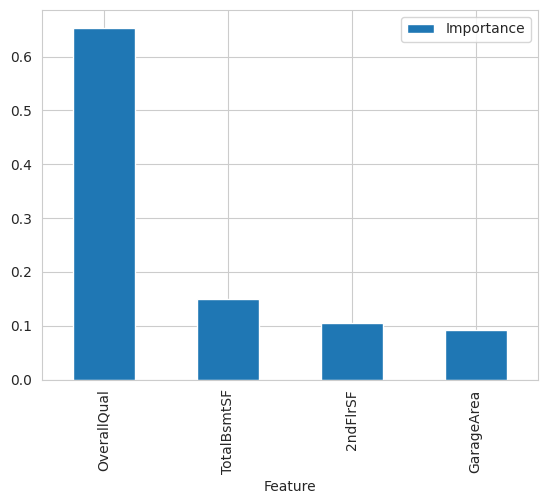

In [39]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

In [ ]:
def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    # plt.show()
    plt.savefig(f'{file_path}/model_performance_evaluation.png', bbox_inches='tight')

regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_regression)